# Checking validation logits

I realized that the validation loss seemed extremely high so I'm checking to see what's going on.

In [1]:
import os
import glob

# https://wandb.ai/jxmorris12/nsynth_chords/runs/2zvf8yr5/logs?workspace=
model_folder = '../outputs/bytedance-20211210-212653/'

model_paths = glob.glob(os.path.join(model_folder, '*'))

import sys
sys.path.append('/home/jxm3/research/transcription/contrastive-pitch-detection')

from models.bytedance import Bytedance_Regress_pedal_Notes
from models.contrastive import ContrastiveModel

min_midi = 60
max_midi = 71
max_polyphony = 3 # for this model
def get_model():
    num_output_nodes = 256 # contrastive embedding dim
    out_activation = None
    
    model = Bytedance_Regress_pedal_Notes(
        num_output_nodes, out_activation, tiny=False
    )
    
    return ContrastiveModel(model, min_midi, max_midi, num_output_nodes, max_polyphony)

import glob
import natsort
import os

model_paths = glob.glob(os.path.join(model_folder, '*'))

model_path = natsort.natsorted(model_paths)[-2]
print('loaded model from:', model_path)

import torch
model = get_model()
model.load_state_dict(torch.load(model_path)['model'])

loaded model from: ../outputs/bytedance-20211210-212653/35_epochs.pth


<All keys matched successfully>

In [37]:
# from dataloader.nsynth import load_nsynth
# dataset = load_nsynth('test', 'keyboard')

import random
random.seed(0)
import tqdm

from dataloader.nsynth_chords import load_nsynth_chords
dataset = load_nsynth_chords('test')

print('loaded', len(dataset), 'tracks')

import random
random.shuffle(dataset)

import numpy as np
from utils.misc import midi_vals_to_categorical, hz_to_midi_v

batch_size = 128

min_midi = 60
max_midi = 71

x = []
y = []
all_midis = []

idx = 0
pbar = tqdm.tqdm(total=batch_size, desc='Loading data')

allowed_notes = set(range(min_midi, max_midi+1))
while len(y) < batch_size:
    idx += 1
    track = dataset[idx]
    start_idx = 0
    end_idx = 16_000
    frequencies = track.get_frequencies_from_offset(start_idx, end_idx)
    midis = np.rint(hz_to_midi_v(frequencies))
    
    if len(frequencies) > max_polyphony:
        continue # skip notes with too high max_polyphony
    elif not set(midis).issubset(allowed_notes):
        continue # skip chords out of range
    else:
        pbar.update(1)
    #
    audio = torch.tensor(track.waveform[start_idx : end_idx], dtype=torch.float32)
    x.append(audio)
    #
    all_midis.append(list(midis))
    categorical = midi_vals_to_categorical(midis, min_midi, max_midi)
    y.append(torch.tensor(categorical, dtype=torch.float32))
x = torch.stack(x)
y = torch.stack(y)
print('loaded audio batch of shape:', x.shape, 'with labels', y.shape)

loading nsynth_chords from disk, split test, take_first_n_seconds=2
loaded 993 tracks


Loading data: 100%|██████████| 128/128 [10:35<00:00,  4.96s/it]

loaded audio batch of shape: torch.Size([128, 16000]) with labels torch.Size([128, 12])


In [84]:
model.eval()

audio_embeddings = model(x)
note_labels = y

loss, (loss_a, loss_n, contrastive_logits) = model.contrastive_loss(audio_embeddings, note_labels)
print(loss, loss_a, loss_n)

tensor(1.5933, grad_fn=<DivBackward0>) tensor(1.5365, grad_fn=<DivBackward1>) tensor(1.6502, grad_fn=<DivBackward1>)


In [39]:
from metrics import f1

y_pred = model.get_probs(audio_embeddings, epsilon=0.0)
f1(y_pred, y)

tensor(0.9887)

## Ok, let me try and visualize this...

In [159]:
import matplotlib.pyplot as plt
def plot_similarities(audio_embeddings, note_labels, figsize=(18,15), a2c=False):
    expected_sims = (note_labels[:,None] == note_labels).all(2).type(torch.float32)
    expected_sims = expected_sims / expected_sims.sum(1)
    
    chord_labels = [(r.nonzero().flatten() + min_midi).detach().cpu().tolist() for r in note_labels] # str labels for axis
    chord_embeddings = model.encode_note_labels(note_labels)

    norm_audio_embeddings = audio_embeddings / torch.norm(audio_embeddings, p=2, dim=1, keepdim=True)
    norm_labels_embeddings = chord_embeddings / torch.norm(chord_embeddings, p=2, dim=1, keepdim=True)
    
    audio_to_chord_sim = (norm_audio_embeddings @ norm_labels_embeddings.T * torch.exp(model.temperature))
    chord_to_audio_sim = audio_to_chord_sim.T
    
    if a2c:
        title='Similarities (audio_to_chord)'
        sims = torch.nn.functional.softmax(audio_to_chord_sim, 0).detach()
    else:
        title='Similarities (chord_to_audio)'
        sims = torch.nn.functional.softmax(chord_to_audio_sim, 1).detach()
    err = sims - expected_sims

    import matplotlib.pyplot as plt
    import seaborn as sns

    fig, ax = plt.subplots(1,3, figsize=(60, 18))
    fig.suptitle(title, fontsize=24)
    
    sns.heatmap(sims, xticklabels=chord_labels, yticklabels=chord_labels, cmap='viridis', vmin=-0.25, vmax=0.25, ax=ax[0])
    ax[0].set_xticks(ax[0].get_xticks(), fontsize=6)
    ax[0].set_yticks(ax[0].get_yticks(), fontsize=6)
    ax[0].set_title(f'{title} [True similarities]', fontsize = 16)
    ax[0].set_xlabel('Audio embeddings', fontsize = 9)
    ax[0].set_ylabel('Chord embeddings', fontsize = 9)
    
    sns.heatmap(expected_sims, xticklabels=chord_labels, yticklabels=chord_labels, cmap='viridis', vmin=-0.25, vmax=0.25, ax=ax[1])
    ax[1].set_xticks(ax[1].get_xticks(), fontsize=6)
    ax[1].set_yticks(ax[1].get_yticks(), fontsize=6)
    ax[1].set_title(f'{title} [Expected similarities]', fontsize = 16)
    ax[1].set_xlabel('Audio embeddings', fontsize = 9)
    ax[1].set_ylabel('Chord embeddings', fontsize = 9)
    
    sns.heatmap(err, xticklabels=chord_labels, yticklabels=chord_labels, cmap='viridis', vmin=-0.25, vmax=0.25, ax=ax[2])
    ax[2].set_xticks(ax[2].get_xticks(), fontsize=6)
    ax[2].set_yticks(ax[2].get_yticks(), fontsize=6)
    ax[2].set_title(f'{title} [Err]', fontsize = 16)
    ax[2].set_xlabel('Audio embeddings', fontsize = 9)
    ax[2].set_ylabel('Chord embeddings', fontsize = 9)
    
    return audio_to_chord_sim, expected_sims, err

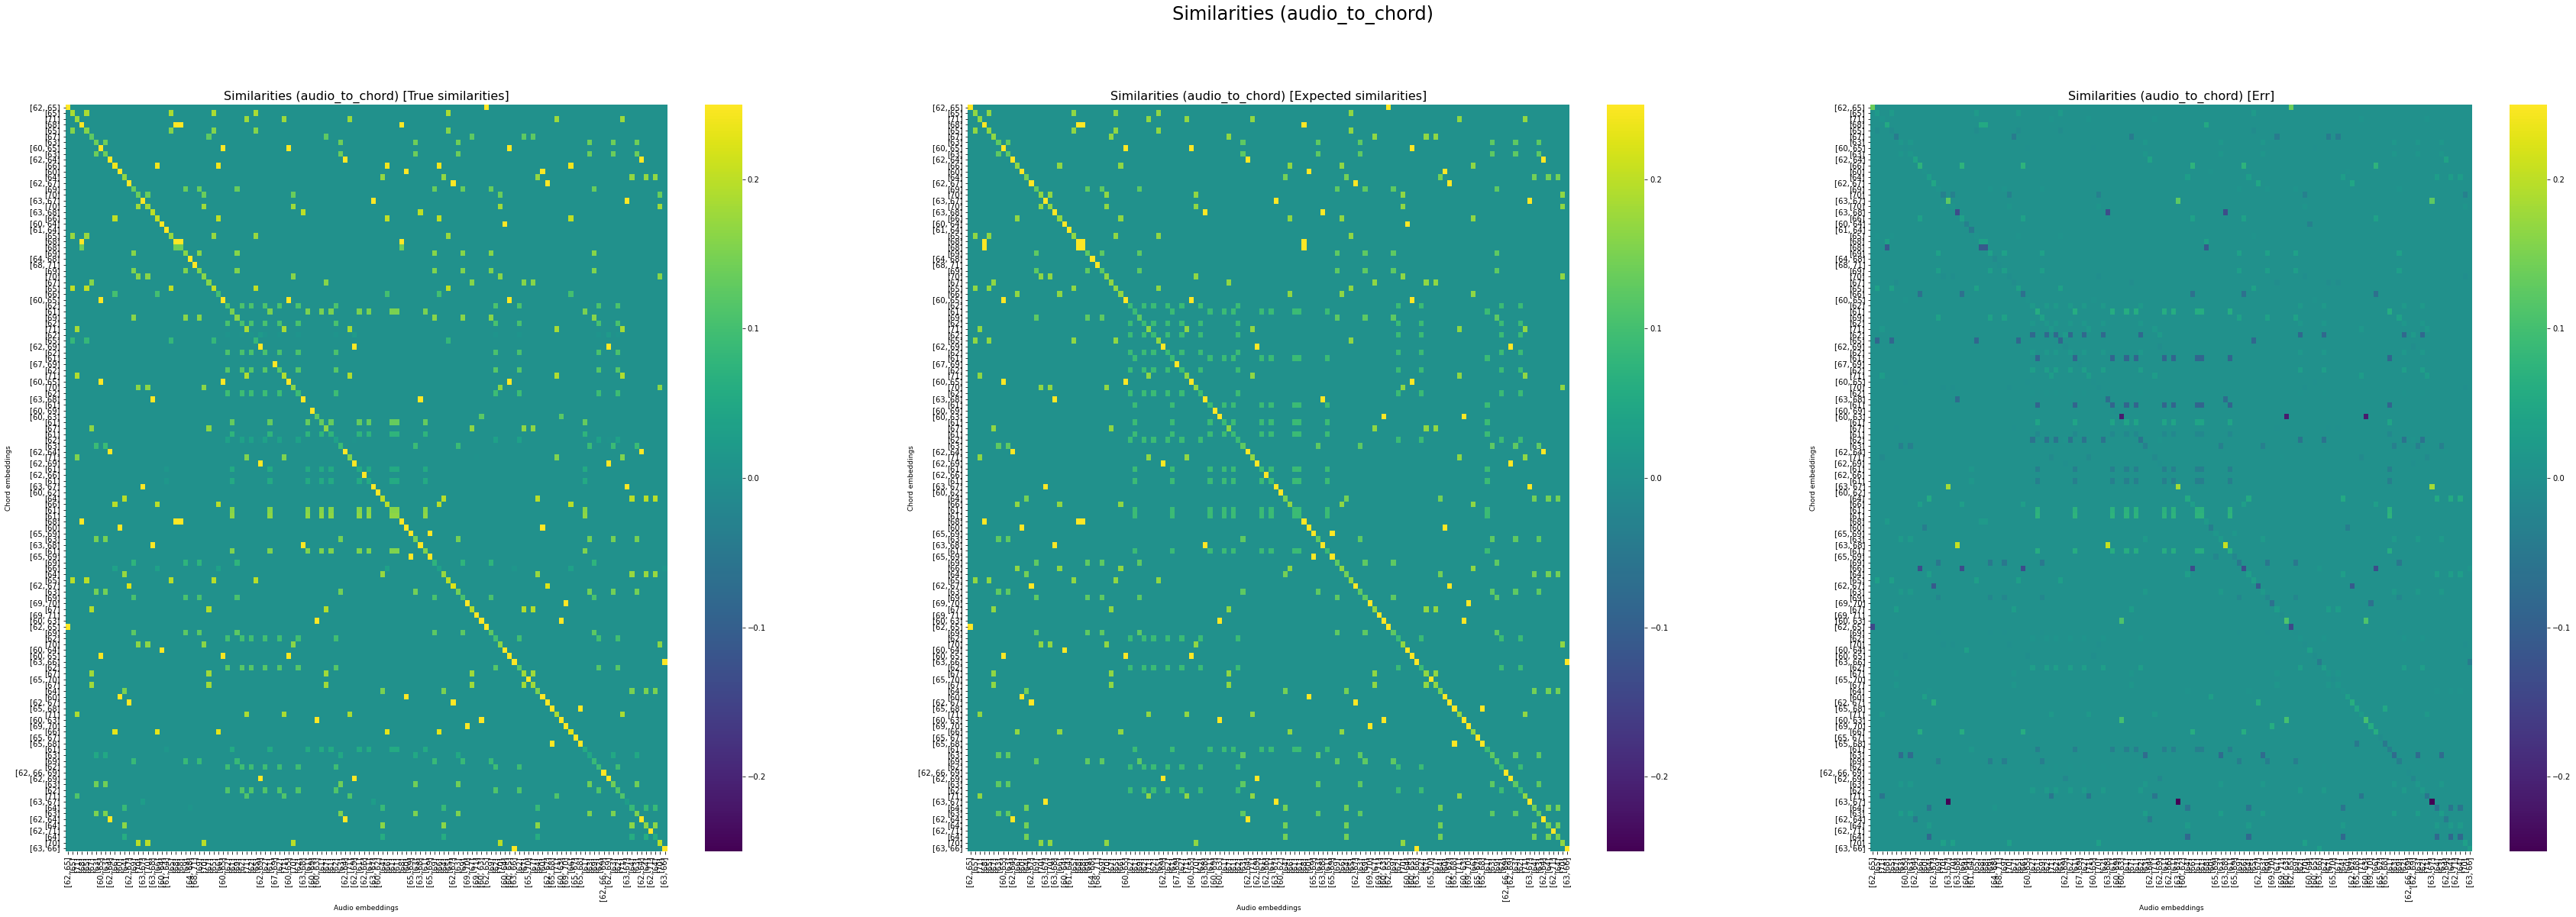

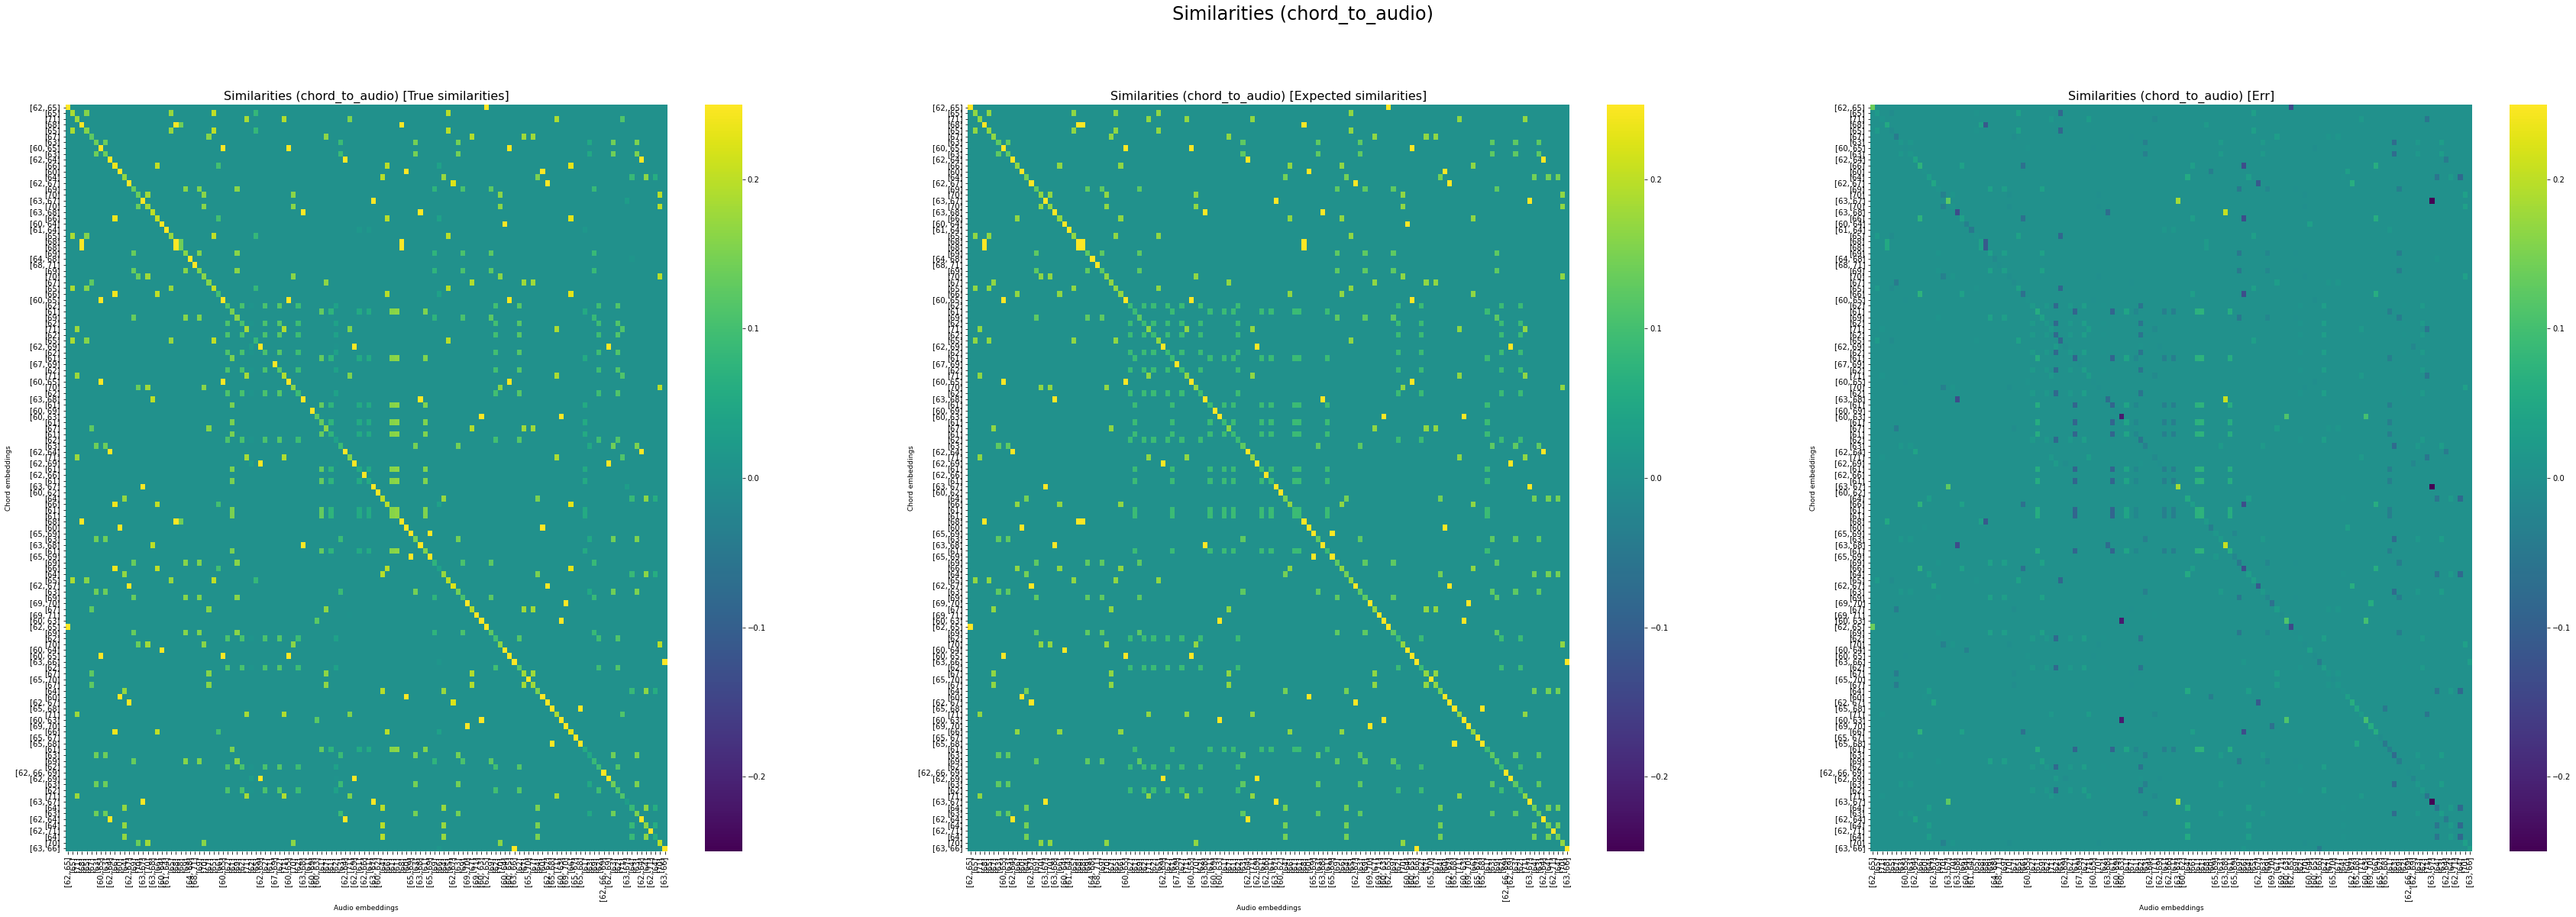

In [160]:
audio_to_chord_sim, expected_sims, err = plot_similarities(audio_embeddings, note_labels, a2c=True)
audio_to_chord_sim, expected_sims, err = plot_similarities(audio_embeddings, note_labels, a2c=False)

In [163]:
torch.nn.functional.cross_entropy(audio_to_chord_sim, expected_sims) # nice, just checking

tensor(1.5365, grad_fn=<DivBackward1>)

In [164]:
torch.nn.functional.cross_entropy(audio_to_chord_sim.T, expected_sims) # nice, just checking

tensor(1.6502, grad_fn=<DivBackward1>)

In [197]:
chord_labels = [str((r.nonzero().flatten() + min_midi).detach().cpu().tolist()) for i, r in enumerate(note_labels)] # str labels for axis
chord_labels_idx = [str(i) + '_' + str((r.nonzero().flatten() + min_midi).detach().cpu().tolist()) for i, r in enumerate(note_labels)] # str labels for axis
# chord_embeddings = model.encode_note_labels(note_labels)

In [183]:
loss_per_audio = torch.nn.functional.cross_entropy(audio_to_chord_sim, expected_sims, reduction='none').detach()
loss_per_chord = torch.nn.functional.cross_entropy(audio_to_chord_sim.T, expected_sims, reduction='none').detach()

In [199]:
import collections
collections.Counter(chord_labels)

Counter({'[62, 65]': 2,
         '[65]': 6,
         '[71]': 6,
         '[68]': 4,
         '[67]': 6,
         '[63]': 8,
         '[60, 65]': 4,
         '[62, 64]': 3,
         '[66]': 6,
         '[60]': 3,
         '[64]': 7,
         '[62, 67]': 3,
         '[69]': 8,
         '[70]': 6,
         '[63, 67]': 3,
         '[63, 68]': 3,
         '[60, 64]': 2,
         '[61, 64]': 1,
         '[64, 68]': 1,
         '[68, 71]': 1,
         '[62]': 11,
         '[61]': 11,
         '[62, 69]': 3,
         '[67, 69]': 1,
         '[60, 69]': 1,
         '[60, 63]': 3,
         '[62, 66]': 1,
         '[60, 62]': 1,
         '[65, 69]': 2,
         '[69, 70]': 2,
         '[69, 71]': 1,
         '[63, 66]': 2,
         '[65, 70]': 1,
         '[65, 68]': 2,
         '[65, 67]': 1,
         '[62, 66, 69]': 1,
         '[62, 71]': 1})

In [204]:
chord_labels[58] # [63] is repeated 8 times in this batch.

'[63]'

In [205]:
# What's its expected labels supposed to be?
expected_sims[58]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1250, 0.0000, 0.1250,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.1250, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.1250, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.1250, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.1250, 

In [206]:
expected_sims[:,58]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1250, 0.0000, 0.1250,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.1250, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.1250, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.1250, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.1250, 

In [215]:
loss_per_audio[58]

tensor(2.0829)

In [216]:
loss_per_chord[58]

tensor(2.1329)

In [218]:
# And what's it actually producing?
_r = lambda t: (t*1000.0).round() / 1000.0
a = _r(torch.nn.functional.softmax(audio_to_chord_sim[58], 0))
a

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1250, 0.0000, 0.1250,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.1250, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.1250, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.1250, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0020, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.1250, 

In [272]:
audio_to_chord_sim[58]

tensor([ 3.7576,  8.5129,  6.4514,  8.7620,  8.5129,  5.9595, 21.6613,  2.0677,
        21.6613,  4.1879, 11.1383,  5.6381,  9.7404,  1.0867, 10.2475,  9.2526,
        11.4209,  9.2526, 14.6421, 11.1383,  1.5090,  2.5577,  8.5129,  8.7620,
         8.7620, 10.2475,  3.7865,  3.2488, 10.2475,  9.2526,  5.9595,  8.5129,
        11.1383,  2.0677, 11.0993,  8.0862, 10.2475, 11.0993,  6.4514, 11.0993,
         8.5129,  4.7200, 11.0993,  8.0862,  2.4015, 11.0993,  6.4514,  2.0677,
         9.2526, 11.0993, 14.6421,  8.0862,  4.1128, 11.7752,  8.0862,  5.9595,
         8.0862, 11.0993, 21.6613,  4.1879,  6.4514,  4.7200,  8.0862,  6.5202,
         8.0862, 11.4209,  2.8201,  9.7404, 11.1383,  8.0862,  8.0862,  8.7620,
         5.6381,  5.4656, 21.6613, 14.6421,  8.0862,  5.4656, 10.2475, 11.1383,
         9.7404,  8.5129,  1.0867, 21.6613, 10.2475,  6.6870,  5.9595,  5.1432,
        11.7752,  3.7576, 10.2475, 11.0993,  9.2526,  1.5090,  2.0677, 17.2558,
        11.0993,  5.9595,  4.5934,  5.95

In [271]:
expected_sims[None, 58]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1250, 0.0000, 0.1250,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.1250, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.1250, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.1250, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

In [262]:
torch.nn.functional.cross_entropy(audio_to_chord_sim[None, 58], expected_sims[None, 58])

tensor(2.0829, grad_fn=<DivBackward1>)

In [288]:
torch.nn.functional.binary_cross_entropy(torch.nn.functional.softmax(audio_to_chord_sim[None, 58], expected_sims[None, 58])

<ipython-input-289-852483eeb331>:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.nn.functional.binary_cross_entropy(torch.nn.functional.softmax(audio_to_chord_sim[None, 58]), expected_sims[None, 58])


tensor(0.0236, grad_fn=<BinaryCrossEntropyBackward0>)

In [ ]:
torch.nn.CrossEntropyLoss()(audio_to_chord_sim[None, 58], expected_sims[None, 58]*8)

tensor(16.6635, grad_fn=<DivBackward1>)

In [ ]:
(torch.nn.functional.softmax(audio_to_chord_sim[58], 0) - expected_sims[58]).abs().sum()b

tensor(0.0070, grad_fn=<SumBackward0>)

In [ ]:
(torch.nn.functional.softmax(audio_to_chord_sim[:], 0) - expected_sims[:]).abs().mean()

tensor(0.0018, grad_fn=<MeanBackward0>)

In [ ]:
a = torch.tensor([[1.0, 0.0, 0.0]])
b = torch.tensor([[0.5, 0.5, 0.0]])


tensor(2.0829, grad_fn=<DivBackward1>)